In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 3c
commitnumber = d62b618
conc = 0.0004
dv = 0.001
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 257
vmax = 800
vmin = 720
w_diffuse = [(1.7, 1.6, 1.8), (1.8, 1.7), (1.5, 1.6, 1.7, 1.8)]
wgt = [(0.6, 0.4, 0.7), (0.7, 0.4), (0.3, 0.4, 0.85, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

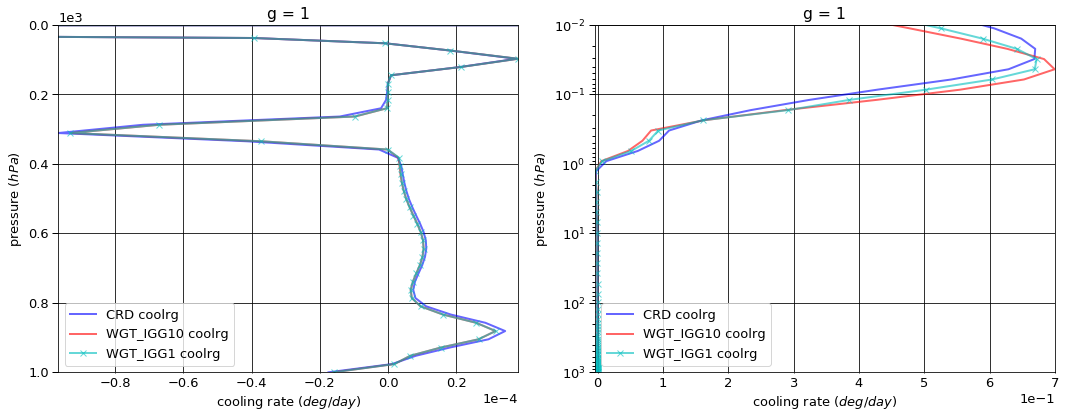

# Figure: cooling rate g-group 2

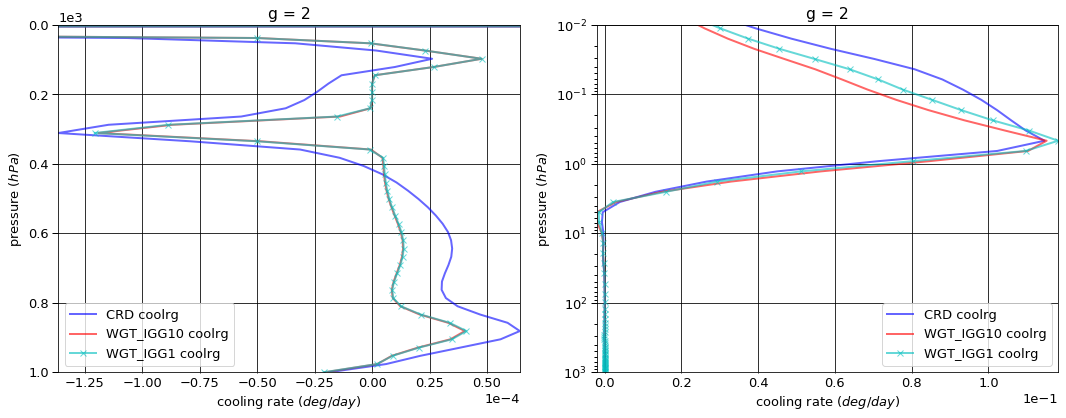

# Figure: cooling rate g-group 3

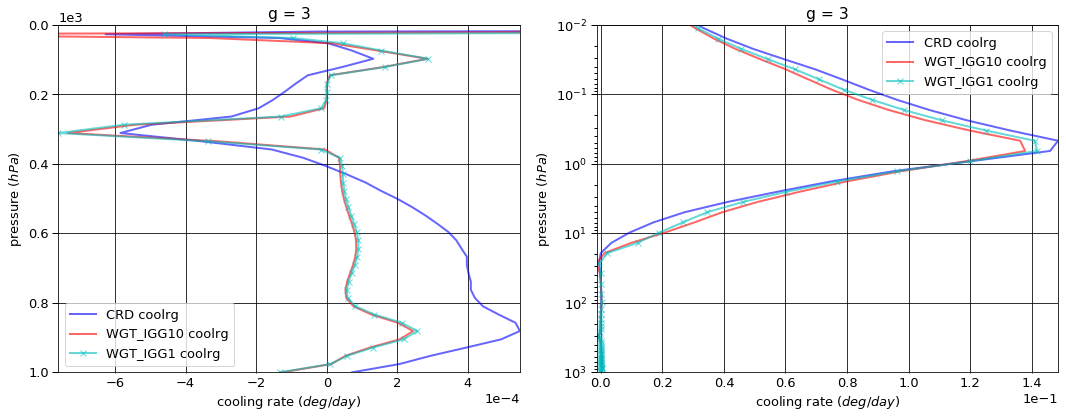

# Figure: cooling rate g-group 4

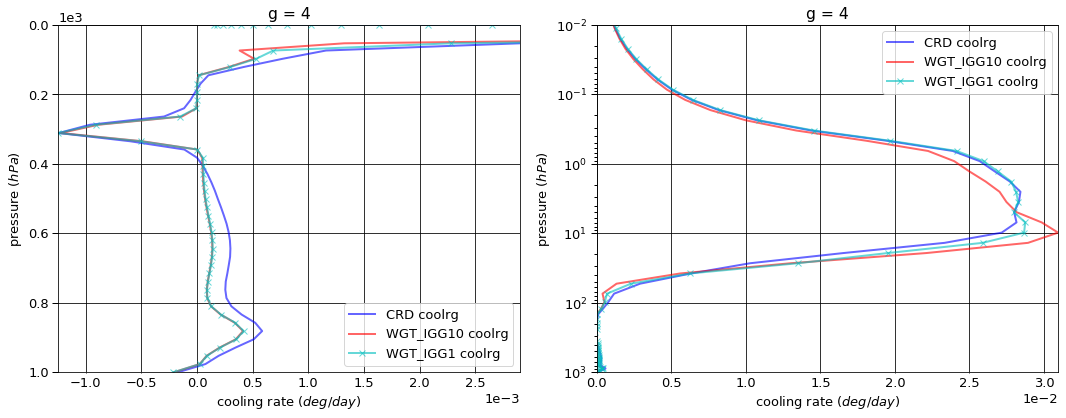

# Figure: cooling rate g-group 5

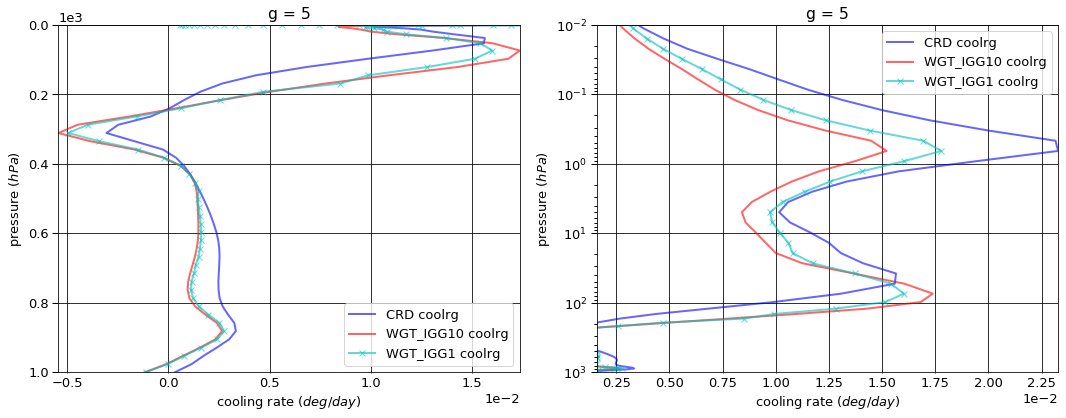

# Figure: cooling rate g-group 6

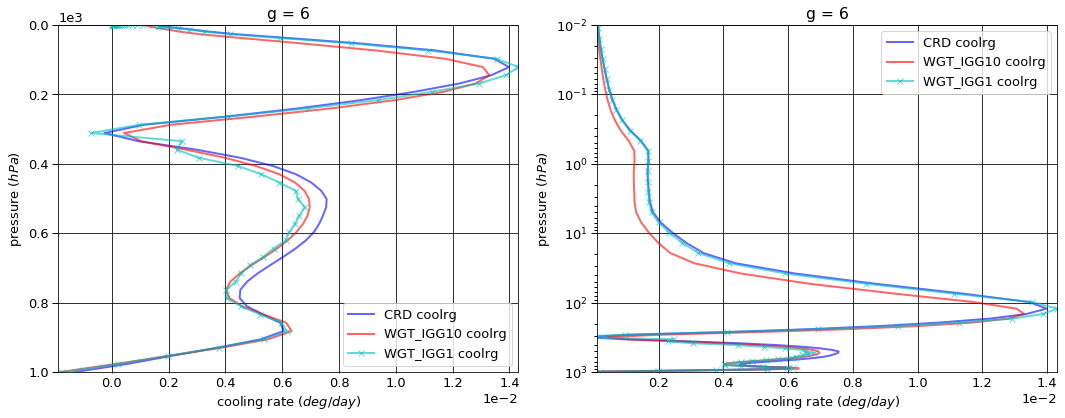

# Figure: cooling rate g-group 7

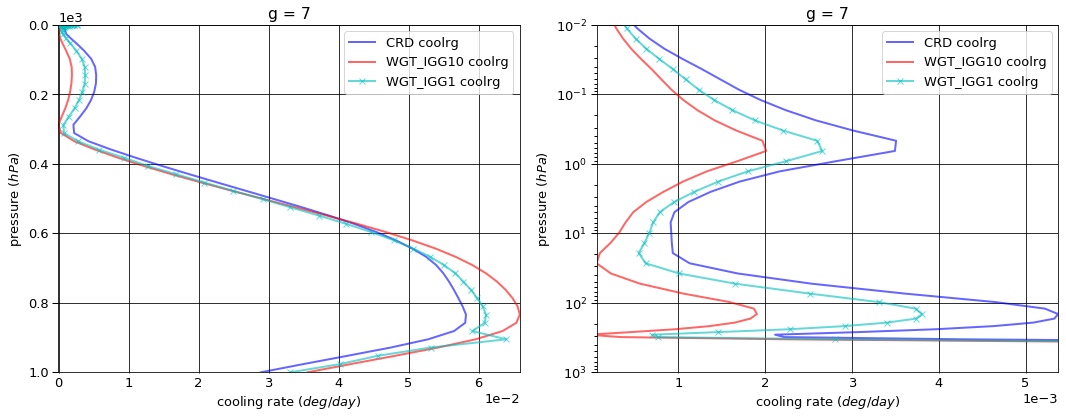

# Figure: cooling rate g-group 8

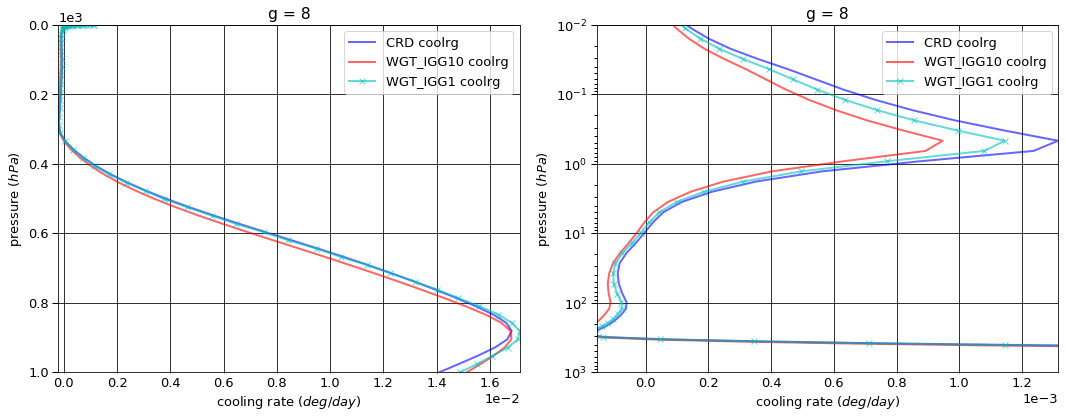

# Figure: cooling rate g-group 9

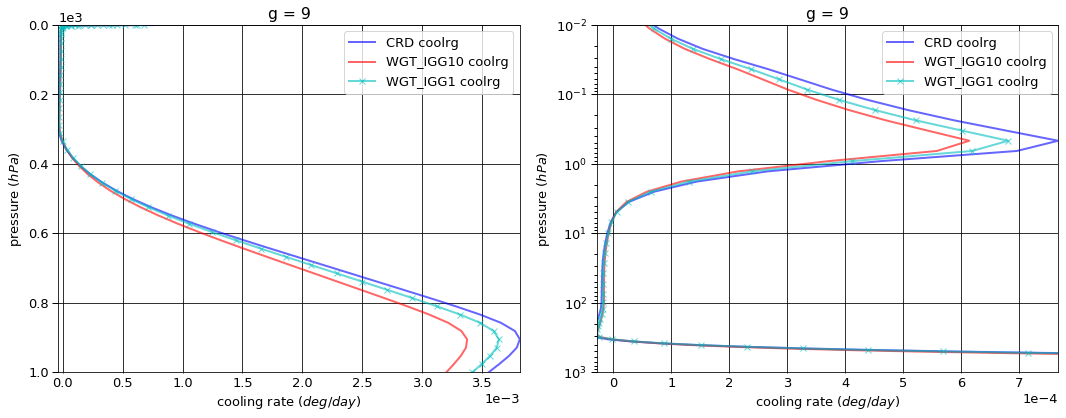

# Figure: cooling rate g-group total

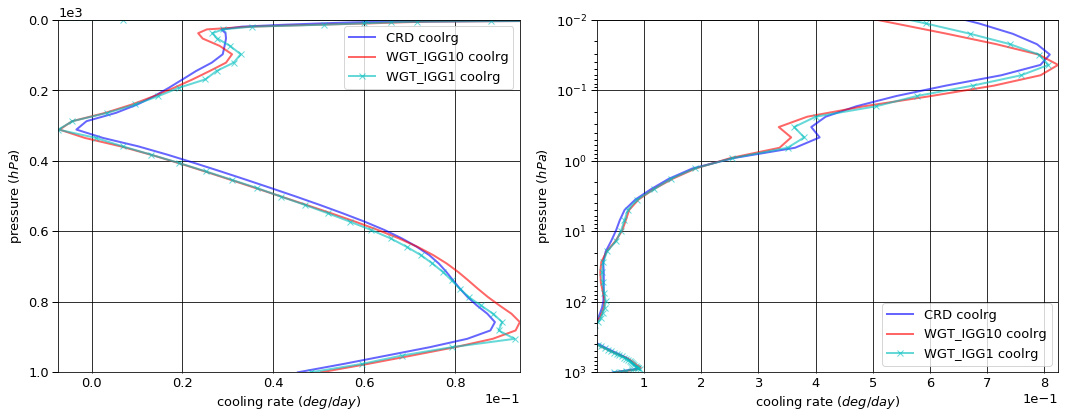

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.014482  0.000000 -0.014482
  1013.0   76    -0.016965  0.017081  0.000115
2 0.0      1     -0.016820  0.000000 -0.016820
  1013.0   76    -0.021240  0.021389  0.000149
3 0.0      1     -0.078066  0.000000 -0.078066
  1013.0   76    -0.126599  0.117695 -0.008903
4 0.0      1     -0.104407  0.000000 -0.104407
  1013.0   76    -0.221960  0.221946 -0.000013
5 0.0      1     -0.410185  0.000000 -0.410185
  1013.0   76    -0.754777  0.694592 -0.060185
6 0.0      1     -0.709892  0.000000 -0.709892
  1013.0   76    -1.355339  1.370420  0.015081
7 0.0      1     -4.491963  0.000000 -4.491963
  1013.0   76    -5.679468  4.602532 -1.076936
8 0.0      1     -3.887110  0.000000 -3.887110
  1013.0   76    -4.014662  0.897214 -3.117447
9 0.0      1     -6.712644  0.000000 -6.712644
  1013.0   76    -6.730513  0.177383 -6.553130


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.014405  0.000000 -0.014405
  1013.0   76    -0.017045  0.017147  0.000103
2 0.0      1     -0.017089  0.000000 -0.017089
  1013.0   76    -0.021320  0.021451  0.000131
3 0.0      1     -0.069241  0.000000 -0.069241
  1013.0   76    -0.127004  0.127802  0.000797
4 0.0      1     -0.098833  0.000000 -0.098833
  1013.0   76    -0.222945  0.224290  0.001345
5 0.0      1     -0.336940  0.000000 -0.336940
  1013.0   76    -0.757054  0.765954  0.008900
6 0.0      1     -0.668357  0.000000 -0.668357
  1013.0   76    -1.360243  1.380606  0.020363
7 0.0      1     -4.551980  0.000000 -4.551980
  1013.0   76    -5.696138  4.710418 -0.985719
8 0.0      1     -3.899859  0.000000 -3.899859
  1013.0   76    -4.011631  0.859616 -3.152015
9 0.0      1     -6.692878  0.000000 -6.692878
  1013.0   76    -6.708143  0.156057 -6.552086


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.014420  0.000000 -0.014420
  1013.0   76    -0.017045  0.017147  0.000103
2 0.0      1     -0.017056  0.000000 -0.017056
  1013.0   76    -0.021320  0.021454  0.000134
3 0.0      1     -0.068869  0.000000 -0.068869
  1013.0   76    -0.127004  0.127840  0.000836
4 0.0      1     -0.099092  0.000000 -0.099092
  1013.0   76    -0.222945  0.224304  0.001359
5 0.0      1     -0.338549  0.000000 -0.338549
  1013.0   76    -0.757054  0.766356  0.009302
6 0.0      1     -0.668383  0.000000 -0.668383
  1013.0   76    -1.360243  1.379310  0.019067
7 0.0      1     -4.504787  0.000000 -4.504787
  1013.0   76    -5.696138  4.648045 -1.048093
8 0.0      1     -3.886309  0.000000 -3.886309
  1013.0   76    -4.011631  0.902382 -3.109249
9 0.0      1     -6.691306  0.000000 -6.691306
  1013.0   76    -6.708143  0.169509 -6.538634


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000077  0.000000  0.000077
  1013.0   76    -0.000079  0.000067 -0.000013
2 0.0      1     -0.000270  0.000000 -0.000270
  1013.0   76    -0.000080  0.000063 -0.000017
3 0.0      1      0.008824  0.000000  0.008824
  1013.0   76    -0.000405  0.010106  0.009701
4 0.0      1      0.005575  0.000000  0.005575
  1013.0   76    -0.000985  0.002344  0.001358
5 0.0      1      0.073245  0.000000  0.073245
  1013.0   76    -0.002278  0.071362  0.069084
6 0.0      1      0.041535  0.000000  0.041535
  1013.0   76    -0.004904  0.010187  0.005283
7 0.0      1     -0.060017  0.000000 -0.060017
  1013.0   76    -0.016670  0.107887  0.091217
8 0.0      1     -0.012749  0.000000 -0.012749
  1013.0   76     0.003031 -0.037598 -0.034567
9 0.0      1      0.019766  0.000000  0.019766
  1013.0   76     0.022370 -0.021326  0.001044


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000062  0.000000  0.000062
  1013.0   76    -0.000079  0.000066 -0.000013
2 0.0      1     -0.000236  0.000000 -0.000236
  1013.0   76    -0.000080  0.000065 -0.000015
3 0.0      1      0.009197  0.000000  0.009197
  1013.0   76    -0.000405  0.010144  0.009739
4 0.0      1      0.005315  0.000000  0.005315
  1013.0   76    -0.000985  0.002358  0.001373
5 0.0      1      0.071635  0.000000  0.071635
  1013.0   76    -0.002278  0.071764  0.069486
6 0.0      1      0.041509  0.000000  0.041509
  1013.0   76    -0.004904  0.008890  0.003986
7 0.0      1     -0.012825  0.000000 -0.012825
  1013.0   76    -0.016670  0.045513  0.028843
8 0.0      1      0.000801  0.000000  0.000801
  1013.0   76     0.003031  0.005168  0.008199
9 0.0      1      0.021338  0.000000  0.021338
  1013.0   76     0.022370 -0.007874  0.014496

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.057213
  1001.112500 75    -0.000017
2 0.000312    1     -0.002912
  1001.112500 75    -0.000019
3 0.000312    1      0.003116
  1001.112500 75     0.000072
4 0.000312    1      0.000126
  1001.112500 75    -0.000173
5 0.000312    1      0.000277
  1001.112500 75     0.000316
6 0.000312    1      0.000016
  1001.112500 75    -0.001349
7 0.000312    1      0.000029
  1001.112500 75     0.028899
8 0.000312    1     -0.000016
  1001.112500 75     0.014101
9 0.000312    1     -0.000014
  1001.112500 75     0.003557


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.045770
  1001.112500 75    -0.000016
2 0.000312    1     -0.000337
  1001.112500 75    -0.000021
3 0.000312    1      0.004805
  1001.112500 75    -0.000126
4 0.000312    1      0.000151
  1001.112500 75    -0.000209
5 0.000312    1      0.000500
  1001.112500 75    -0.001177
6 0.000312    1      0.000012
  1001.112500 75    -0.001884
7 0.000312    1     -0.000002
  1001.112500 75     0.035573
8 0.000312    1     -0.000016
  1001.112500 75     0.015138
9 0.000312    1     -0.000012
  1001.112500 75     0.003204


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.016662
  1001.112500 75    -0.000016
2 0.000312    1     -0.001609
  1001.112500 75    -0.000021
3 0.000312    1      0.004189
  1001.112500 75    -0.000133
4 0.000312    1      0.000156
  1001.112500 75    -0.000212
5 0.000312    1      0.000582
  1001.112500 75    -0.001111
6 0.000312    1      0.000017
  1001.112500 75    -0.001750
7 0.000312    1      0.000018
  1001.112500 75     0.033121
8 0.000312    1     -0.000015
  1001.112500 75     0.014883
9 0.000312    1     -0.000013
  1001.112500 75     0.003422


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.029833e-01
  1001.112500 75     1.488000e-06
2 0.000312    1      2.575340e-03
  1001.112500 75    -1.825048e-06
3 0.000312    1      1.689089e-03
  1001.112500 75    -1.977631e-04
4 0.000312    1      2.503122e-05
  1001.112500 75    -3.646360e-05
5 0.000312    1      2.226668e-04
  1001.112500 75    -1.493230e-03
6 0.000312    1     -3.948525e-06
  1001.112500 75    -5.349770e-04
7 0.000312    1     -3.126159e-05
  1001.112500 75     6.674713e-03
8 0.000312    1     -3.762150e-07
  1001.112500 75     1.036768e-03
9 0.000312    1      2.274223e-06
  1001.112500 75    -3.534867e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -7.387496e-02
  1001.112500 75     1.491095e-06
2 0.000312    1      1.303274e-03
  1001.112500 75    -2.313941e-06
3 0.000312    1      1.073458e-03
  1001.112500 75    -2.050125e-04
4 0.000312    1      2.935575e-05
  1001.112500 75    -3.965076e-05
5 0.000312    1      3.052701e-04
  1001.112500 75    -1.426764e-03
6 0.000312    1      9.865990e-07
  1001.112500 75    -4.010396e-04
7 0.000312    1     -1.096294e-05
  1001.112500 75     4.222176e-03
8 0.000312    1      4.712300e-07
  1001.112500 75     7.816940e-04
9 0.000312    1      1.255248e-06
  1001.112500 75    -1.354606e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.425568,0.000000,-16.425568
1013.0,76,-18.921523,8.120252,-10.801271



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.349583,0.000000,-16.349583
1013.0,76,-18.921523,8.263342,-10.658181



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.288771,0.000000,-16.288771
1013.0,76,-18.921523,8.256346,-10.665177



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,7.598485e-02,0.00000,0.075985
1013.0,76,-7.100000e-08,0.14309,0.143090



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.367976e-01,0.000000,0.136798
1013.0,76,-7.100000e-08,0.136094,0.136094


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.057836
1001.112500,75,0.045386



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.040668
1001.112500,75,0.050481



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.013336
1001.112500,75,0.048181



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.098504
1001.112500,75,0.005095



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.071172
1001.112500,75,0.002795


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000850,0.000901
2,0.001075,0.001127
3,0.006450,0.006712
4,0.011150,0.011783
5,0.038525,0.040010
6,0.068675,0.071889
7,0.290038,0.301040
8,0.213775,0.212014
9,0.369463,0.354524


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.310867e-19
2,2.133976e-20
3,1.970626e-21
4,1.774707e-21
5,1.647913e-22
6,5.838237e-22
7,6.101170e-23
8,6.375943e-24
9,2.959058e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.310867e-19,NaN,0.000850,0.000901,0.000850,0.000901,1.0
2,2.133976e-20,0.092345,0.001075,0.001127,0.001925,0.002028,1.0
3,1.970626e-21,0.092345,0.006450,0.006712,0.008375,0.008740,1.0
4,1.774707e-21,0.900580,0.011150,0.011783,0.019525,0.020522,10.0
5,1.647913e-22,0.092856,0.038525,0.040010,0.058050,0.060533,10.0
6,5.838237e-22,3.542806,0.068675,0.071889,0.126725,0.132421,500.0
7,6.101170e-23,0.104504,0.290038,0.301040,0.416763,0.433461,500.0
8,6.375943e-24,0.104504,0.213775,0.212014,0.630537,0.645476,500.0
9,2.959058e-25,0.046410,0.369463,0.354524,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
